<a href="https://colab.research.google.com/github/aSafarpoor/Dataset-Test/blob/main/Who_is_SNAP_DATASET%3F_(Twitter_Case).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://snap.stanford.edu/data/twitter_combined.txt.gz
!gunzip -c twitter_combined.txt.gz > twitter_edge.txt

--2025-05-07 01:20:19--  https://snap.stanford.edu/data/twitter_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10621918 (10M) [application/x-gzip]
Saving to: ‘twitter_combined.txt.gz’

twitter_combined.tx 100%[===================>]  10.13M  1.85MB/s    in 6.0s    

2025-05-07 01:20:25 (1.70 MB/s) - ‘twitter_combined.txt.gz’ saved [10621918/10621918]



In [ ]:
!pip install networkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 62.7 MB/s eta 0:00:00


In [ ]:

import numpy as np
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import torch
from collections import deque, defaultdict
import community  # This is from the 'python-louvain' package
from scipy.stats import entropy
import math
import networkit as nk
from networkx.algorithms.approximation import maxcut

In [ ]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print("torch: imported")
    except:
        print("torch: not imported")
    print(f"Random set by seed = {seed}")

set_random_seed(seed = 1)

torch: imported
Random set by seed = 1


In [ ]:
edges = []
with open('twitter_edge.txt', 'r') as f:
    for line in f:
        u, v = map(int, line.strip().split())
        edges.append([u, v])

In [ ]:
G = nx.DiGraph()
G.add_edges_from(edges)
mapping = {old: new for new, old in enumerate(sorted(G.nodes()), start=1)} # eindex nodes to 1..n
G = nx.relabel_nodes(G, mapping)
UG = G.to_undirected()

# simple parameters

## Single Simple Value

In [ ]:
def analyze_graph(G):
    num_nodes = G.number_of_nodes()
    print("Number of nodes:", num_nodes)
    print("Number of edges:", G.number_of_edges())

    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())

        avg_in_deg = sum(in_degrees.values()) / num_nodes
        avg_out_deg = sum(out_degrees.values()) / num_nodes
        degrees = [in_degrees[n] + out_degrees[n] for n in G.nodes()]

        only_in = sum(1 for n in G.nodes() if in_degrees[n] > 0 and out_degrees[n] == 0)
        only_out = sum(1 for n in G.nodes() if in_degrees[n] == 0 and out_degrees[n] > 0)
        both = sum(1 for n in G.nodes() if in_degrees[n] > 0 and out_degrees[n] > 0)
        isolated = sum(1 for n in G.nodes() if in_degrees[n] == 0 and out_degrees[n] == 0)

        print("Average in-degree:", round(avg_in_deg, 3))
        print("Average out-degree:", round(avg_out_deg, 3))
        print("Only in-edge nodes ratio:", round(only_in / num_nodes, 3))
        print("Only out-edge nodes ratio:", round(only_out / num_nodes, 3))
        print("Nodes with both in and out edges ratio:", round(both / num_nodes, 3))
        print("Isolated nodes ratio:", round(isolated / num_nodes, 3))
    else:
        degrees = dict(G.degree()).values()
        avg_in_deg = avg_out_deg = None
        isolated = sum(1 for n in G.nodes() if G.degree(n) == 0)
        print("Average degree:", round(sum(degrees) / num_nodes, 3))
        print("Isolated nodes ratio:", round(isolated / num_nodes, 3))

    print("Maximum degree:", max(degrees))
    leaf_nodes = [n for n in G.nodes() if G.degree(n) == 1]
    print("Number of leaf nodes:", len(leaf_nodes))

In [ ]:
analyze_graph(G)

Number of nodes: 81306
Number of edges: 1768149
Average in-degree: 21.747
Average out-degree: 21.747
Only in-edge nodes ratio: 0.138
Only out-edge nodes ratio: 0.0
Nodes with both in and out edges ratio: 0.862
Isolated nodes ratio: 0.0
Maximum degree: 3758
Number of leaf nodes: 4995


In [ ]:
analyze_graph(UG)

Number of nodes: 81306
Number of edges: 1342310
Average degree: 33.019
Isolated nodes ratio: 0.0
Maximum degree: 3383
Number of leaf nodes: 4995


In [ ]:
def print_sparsity_ratio(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(n,m)
    if nx.is_directed(G):
        max_edges = n * (n - 1)
        print("Graph is directed.")
    else:
        max_edges = n * (n - 1) // 2
        print("Graph is undirected.")

    if max_edges == 0:
        sparsity_ratio = 0.0
    else:
        sparsity_ratio = m / max_edges

    print(f"Sparsity ratio: {sparsity_ratio:.6f}")

In [ ]:
print_sparsity_ratio(G)

81306 1768149
Graph is directed.
Sparsity ratio: 0.000267


In [ ]:
print_sparsity_ratio(UG)

81306 1342310
Graph is undirected.
Sparsity ratio: 0.000406


In [ ]:
def largest_connected_component(UG):
    components = list(nx.connected_components(UG))
    largest = max(components, key=len)
    UG_largest = UG.subgraph(largest).copy()
    print(f"Number of nodes in largest component: {UG_largest.number_of_nodes()}")
    print(f"Number of edges in largest component: {UG_largest.number_of_edges()}")
    print(f"#edge/#node = {round(UG_largest.number_of_edges()/UG_largest.number_of_nodes(),2)}")
    return UG_largest
UGlCC = largest_connected_component(UG)

Number of nodes in largest component: 81306
Number of edges in largest component: 1342310
#edge/#node = 16.51


In [ ]:
def largest_strongly_connected_component(G):
    components = list(nx.strongly_connected_components(G))
    largest = max(components, key=len)
    G_largest = G.subgraph(largest).copy()
    print(f"Number of nodes in largest strongly connected component: {G_largest.number_of_nodes()}")
    print(f"Number of edges in largest strongly connected component: {G_largest.number_of_edges()}")
    print(f"#edge/#node = {round(G_largest.number_of_edges() / G_largest.number_of_nodes(), 2)}")
    return G_largest

GlSCC = largest_strongly_connected_component(G)

Number of nodes in largest strongly connected component: 68413
Number of edges in largest strongly connected component: 1685163
#edge/#node = 24.63


In [ ]:
def analyze_scc_components(G):
    if not isinstance(G, nx.DiGraph):
        raise ValueError("G must be a directed graph")

    def report_sccs(graph, label):
        sccs = list(nx.strongly_connected_components(graph))
        sizes = [len(c) for c in sccs]
        small = [s for s in sizes if s < 10]
        large = sorted([s for s in sizes if s >= 10], reverse=True)

        print(f"\nSCC Analysis for {label}:")
        print(f"Total number of SCCs: {len(sccs)}")
        print(f"Number of SCCs with size < 10: {len(small)}")
        print(f"Sizes of SCCs with size ≥ 10 (sorted): {large}")

    report_sccs(G, "original G")


analyze_scc_components(G)


SCC Analysis for original G:
Total number of SCCs: 12248
Number of SCCs with size < 10: 12242
Sizes of SCCs with size ≥ 10 (sorted): [68413, 73, 53, 20, 18, 14]


## Degree Distribution

In [ ]:
def clip_top_5_percent(values):
    values = np.array(values)
    threshold = np.percentile(values, 97)  # 95th percentile value
    clip_val = np.min(values[values >= threshold])
    clipped = np.where(values > clip_val, clip_val, values)
    return clipped, clip_val

def plot_degree_distributions(G, name="Graph"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    if G.is_directed():
        in_degrees = [d for _, d in G.in_degree()]
        out_degrees = [d for _, d in G.out_degree()]
        total_degrees = [in_d + out_d for in_d, out_d in zip(in_degrees, out_degrees)]
    else:
        in_degrees = out_degrees = total_degrees = [d for _, d in G.degree()]

    # Clip top 5% of each list
    total_degrees_clipped, clip_total = clip_top_5_percent(total_degrees)
    in_degrees_clipped, clip_in = clip_top_5_percent(in_degrees)
    out_degrees_clipped, clip_out = clip_top_5_percent(out_degrees)

    # Plot Degree
    axes[0].hist(total_degrees_clipped, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f"{name} - Degree")
    axes[0].set_xlabel("Degree")
    axes[0].set_ylabel("Frequency")

    # Plot In-Degree
    axes[1].hist(in_degrees_clipped, bins=30, color='lightgreen', edgecolor='black')
    axes[1].set_title(f"{name} - In-Degree")
    axes[1].set_xlabel("In-Degree")
    axes[1].set_ylabel("Frequency")

    # Plot Out-Degree
    axes[2].hist(out_degrees_clipped, bins=30, color='salmon', edgecolor='black')
    axes[2].set_title(f"{name} - Out-Degree")
    axes[2].set_xlabel("Out-Degree")
    axes[2].set_ylabel("Frequency")

    # Add clipping info
    fig.suptitle(f"Degree Distributions for {name}", fontsize=16)
    fig.text(0.5, 0.01, f"Clipped top 3% values to: Degree={clip_total}, In-Degree={clip_in}, Out-Degree={clip_out}",
             ha='center', fontsize=10, style='italic')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


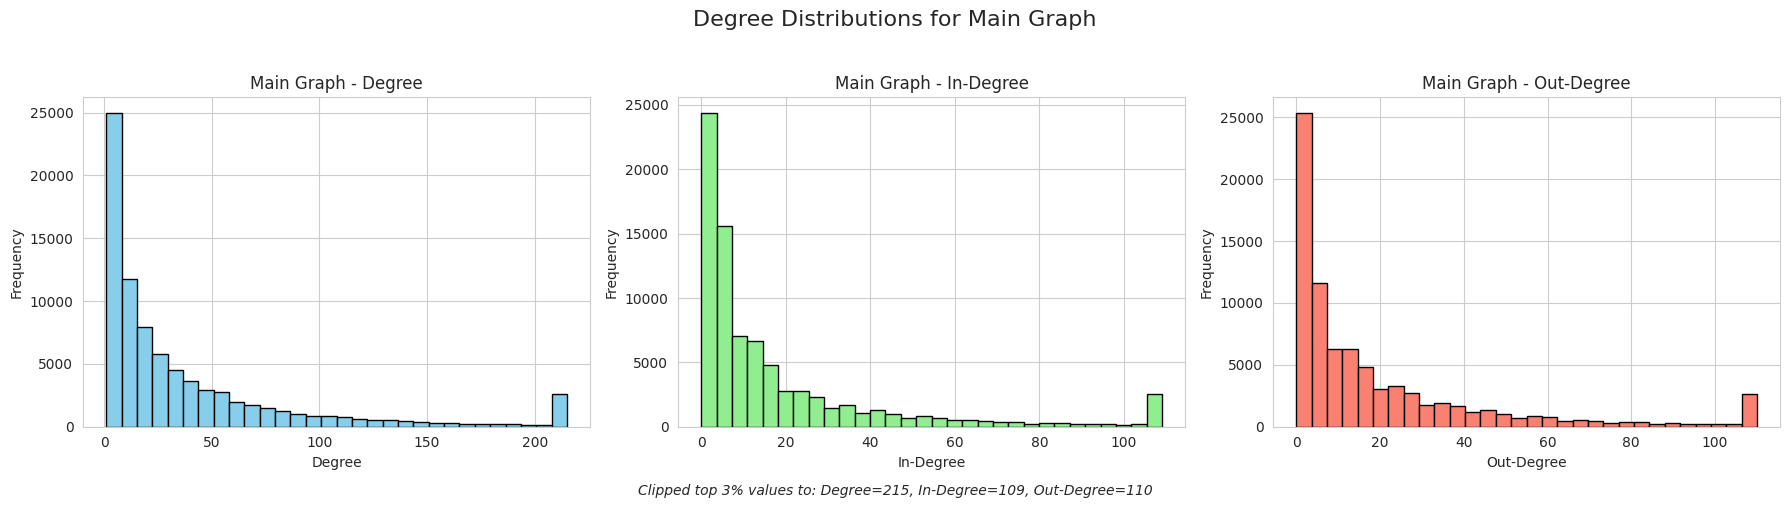

In [ ]:
plot_degree_distributions(G, name="Main Graph")

# BFS (undirected scenario)

In [ ]:
def bfs_levels_from_virtual_node(G, first_level_list):
    G = G.copy()
    virtual_node = -1

    G.add_node(virtual_node)
    for node in first_level_list:
        G.add_edge(virtual_node, node)

    visited = set([virtual_node])
    level_map = {virtual_node: 0}
    queue = deque([virtual_node])

    level_nodes = defaultdict(list)

    while queue:
        current = queue.popleft()
        current_level = level_map[current]

        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                level_map[neighbor] = current_level + 1
                level_nodes[current_level + 1].append(neighbor)
                queue.append(neighbor)


    original_nodes = set(G.nodes()) - {virtual_node}
    print("BFS Level Summary (excluding virtual node):")
    for level in sorted(level_nodes.keys()):
        nodes_at_level = level_nodes[level]
        avg_deg = sum(G.degree(n) for n in nodes_at_level) / len(nodes_at_level)
        print(f"Level {level}: {len(nodes_at_level)} nodes, average degree: {round(avg_deg, 2)}")

    all_reachable = set(level_map.keys()) - {virtual_node}
    non_reachable = original_nodes - all_reachable
    isolated_nodes = list(nx.isolates(G))
    num_non_reachable = len(non_reachable)
    num_isolated_non_reachable = len(set(isolated_nodes) & non_reachable)

    if len(original_nodes) > 0:
        print(f"Non-reachable nodes: {num_non_reachable} ({round(num_non_reachable / len(original_nodes) * 100, 2)}%)")
        if num_non_reachable > 0:
            isolated_ratio = num_isolated_non_reachable / num_non_reachable
            print(f"Among the unreachabel, isolated nodes: {num_isolated_non_reachable} ({round(isolated_ratio * 100, 2)}%)")

    else:
        print("No nodes in the original graph.")


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.4) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 32522 nodes, average degree: 34.34
Level 2: 44824 nodes, average degree: 35.51
Level 3: 3960 nodes, average degree: 2.16
Non-reachable nodes: 0 (0.0%)


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.4) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 32522 nodes, average degree: 33.88
Level 2: 44884 nodes, average degree: 35.8
Level 3: 3900 nodes, average degree: 2.15
Non-reachable nodes: 0 (0.0%)


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.1) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 8130 nodes, average degree: 34.42
Level 2: 50107 nodes, average degree: 45.43
Level 3: 23069 nodes, average degree: 5.91
Non-reachable nodes: 0 (0.0%)


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.01) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 813 nodes, average degree: 35.09
Level 2: 17691 nodes, average degree: 83.59
Level 3: 58153 nodes, average degree: 19.74
Level 4: 4649 nodes, average degree: 6.56
Non-reachable nodes: 0 (0.0%)


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.01) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 813 nodes, average degree: 34.74
Level 2: 17832 nodes, average degree: 83.36
Level 3: 57462 nodes, average degree: 19.75
Level 4: 5199 nodes, average degree: 6.91
Non-reachable nodes: 0 (0.0%)


In [ ]:
subset = random.sample(list(UG.nodes()),int(UG.number_of_nodes()*0.1) )

bfs_levels_from_virtual_node(UG, first_level_list = subset) # whole labeled nodes

BFS Level Summary (excluding virtual node):
Level 1: 8130 nodes, average degree: 33.92
Level 2: 49909 nodes, average degree: 45.66
Level 3: 23212 nodes, average degree: 5.92
Level 4: 55 nodes, average degree: 11.05
Non-reachable nodes: 0 (0.0%)


# Talk abput connected components

Number of connected components: 1


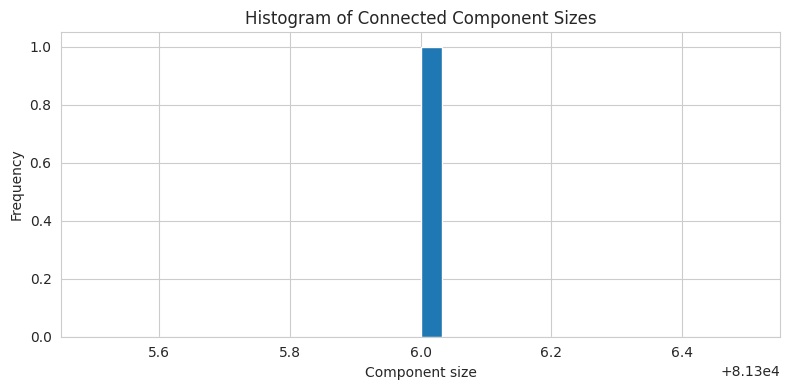

In [ ]:
def analyze_connected_components(UG):

    components = list(nx.connected_components(UG))
    sizes = [len(c) for c in components]

    print(f"Number of connected components: {len(components)}")

    plt.figure(figsize=(8, 4))
    plt.hist(sizes, bins=30)
    plt.xlabel("Component size")
    plt.ylabel("Frequency")
    plt.title("Histogram of Connected Component Sizes")
    plt.tight_layout()
    plt.show()

    return sizes

sizes = analyze_connected_components(UG)

Number of strongly connected components: 12248


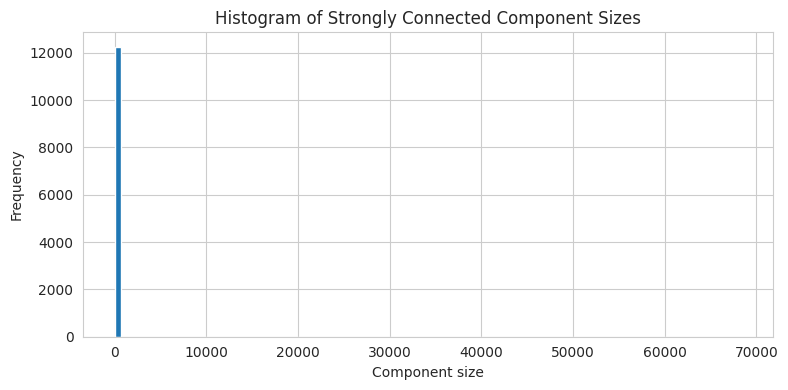

In [ ]:
def analyze_strongly_connected_components(G):
    # Step 1: Compute strongly connected components
    components = list(nx.strongly_connected_components(G))
    sizes = [len(c) for c in components]

    # Step 2: Print number of SCCs
    print(f"Number of strongly connected components: {len(components)}")

    # Step 3: Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(sizes, bins=100)
    plt.xlabel("Component size")
    plt.ylabel("Frequency")
    plt.title("Histogram of Strongly Connected Component Sizes")
    plt.tight_layout()
    plt.show()

    return sizes

sizes = analyze_strongly_connected_components(G)

# clustering

In [ ]:
import community as community_louvain
from collections import defaultdict

def analyze_louvain_clustering(UG):
    partition = community_louvain.best_partition(UG)

    clusters = defaultdict(list)
    for node, cid in partition.items():
        clusters[cid].append(node)

    print(f"Number of clusters: {len(clusters)}")

    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)

    cluster_sizes = []
    cluster_edges = []
    for _, nodes in sorted_clusters:
        subgraph = UG.subgraph(nodes)
        cluster_sizes.append(len(nodes))
        cluster_edges.append(subgraph.number_of_edges()/len(nodes))

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axes[0].bar(range(len(cluster_sizes)), cluster_sizes)
    axes[0].set_ylabel("Cluster Size")
    axes[0].set_title("Sizes of Louvain Clusters")

    axes[1].bar(range(len(cluster_edges)), cluster_edges)
    axes[1].set_ylabel("Internal # Edges / # Nodes")
    axes[1].set_title("# Edges / # Nodes in Each Cluster")
    axes[1].set_xlabel("Cluster Index (Sorted by Size)")

    plt.tight_layout()
    plt.show()

Number of clusters: 70


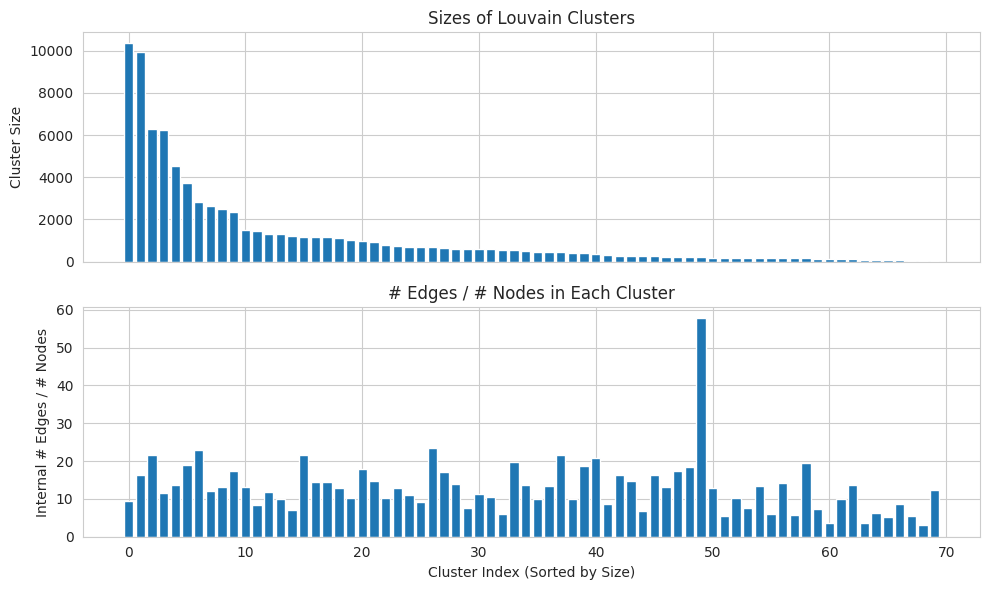

In [ ]:
analyze_louvain_clustering(UG)

# More parameters

In [ ]:
def compute_graph_metrics(G, UG, UC_largest_component):

    results = {}

    # 1. Global Clustering Coefficient
    # Meaning: Fraction of closed triplets (triangles) over all connected triplets
    # Use: High in social networks (0.3–0.6); low (<0.1) suggests weak community
    # Complexity: O(n * d^2)
    gcc = nx.transitivity(UG)
    results['Global Clustering Coefficient'] = gcc

    # 2. Average Clustering Coefficient
    # Meaning: Average local clustering over all nodes
    # Use: Similar to GCC; high (>0.3) = strong local communities
    # Complexity: O(n * d^2)
    acc = nx.average_clustering(UG)
    results['Average Clustering Coefficient'] = acc

    # 3. Degree Assortativity Coefficient
    # Meaning: Correlation of degree between connected nodes
    # Use: Positive in social graphs; negative in hubs-to-lows (e.g., sybils)
    # Complexity: O(m)
    assort = nx.degree_assortativity_coefficient(UG)
    results['Degree Assortativity'] = assort

    # 4. Diameter (Approximated)
    # Meaning: Longest shortest path; smaller = tighter network
    # Use: OSNs typically have small diameter (6–10)
    # Complexity: O(n) using approximation like eccentricity sampling
    try:
        from networkx.algorithms.approximation import diameter as approx_diameter
        diam = approx_diameter(UC_largest_component)
    except:
        diam = -1  # fallback if approximation not available
    results['Approx. Diameter'] = diam

    # 5. Reciprocity
    # Meaning: Ratio of mutual edges to total directed edges
    # Use: High (0.3–0.6) in mutual-friend OSNs; low in follower networks
    # Complexity: O(m)
    rec = nx.reciprocity(G)
    results['Reciprocity'] = rec

    # 6. K-core Number
    # Meaning: Max k such that G has a non-empty k-core (each node has >=k neighbors)
    # Use: High k-core depth (e.g., >10) suggests dense real OSNs
    # Complexity: O(n + m)
    try:
        kcore = max(nx.core_number(UG).values())
    except:
        kcore = -1
    results['K-core Max'] = kcore

    # 7. PageRank Entropy (instead of list)
    # Meaning: Influence score of nodes via link structure
    # Use: Real OSNs have skewed PageRank; uniform = fake/flat
    # Complexity: O(k(n + m))
    pr = nx.pagerank(G, alpha=0.85)
    pr_values = np.array(list(pr.values()))
    pr_entropy = -np.sum(pr_values * np.log(pr_values + 1e-10))  # entropy as a number
    results['PageRank Entropy'] = pr_entropy

    # Print with explanations
    for key, val in results.items():
        print(f"{key}: {val:.4f}")

    # return results


In [ ]:
compute_graph_metrics(G, UG, UGlCC)

Global Clustering Coefficient: 0.1706
Average Clustering Coefficient: 0.5653
Degree Assortativity: -0.0390
Approx. Diameter: 7.0000
Reciprocity: 0.4817
K-core Max: -1.0000
PageRank Entropy: 10.5412


In [ ]:
# Gini coefficient formula:
# Measures inequality in the degree distribution of the graph.
# 0 = perfect equality (all nodes same degree)
# 1 = maximal inequality (one node connects to all, others to none)

# Interpretation (comment only):
#  Gini ≈ 0.0–0.2 → Very equal degree distribution
#  Gini ≈ 0.2–0.4 → Moderately equal
#  Gini ≈ 0.4–0.6 → Noticeable inequality
#  Gini ≈ 0.6–0.8 → Strong hubs dominate
#  Gini ≈ 0.8–1.0 → Star-like or scale-free dominance


def compute_gini_coefficient(G):
    degrees = np.array([deg for _, deg in G.degree()])
    sorted_degrees = np.sort(degrees)
    n = len(degrees)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_degrees))) / (n * np.sum(sorted_degrees)) - (n + 1) / n
    return gini

compute_gini_coefficient(UG)

np.float64(0.6398859372929051)

In [ ]:
# Edge Reciprocity
# Measures fraction of directed edges that are reciprocated

# Interpretation (comment only):
#  - Value in [0, 1]
#  - 0.0 → No mutual links at all
#  - 1.0 → All links are bidirectional
#  - High values suggest social-like structure; low values may suggest spam/sybil or hierarchy

def compute_edge_reciprocity(G):
    if not G.is_directed():
        return None
    return nx.reciprocity(G)  # Float in [0, 1]

print(compute_edge_reciprocity(G))

0.48167773191060254


In [ ]:
# Approximate average, max, and std of shortest path lengths using random sampling

# Interpretation (comment only):
#  - Average shortest path length → how close nodes are on average
#  - Std → variation in distances (dispersion)
#  - Max → approximate graph diameter (upper bound)

def approximate_shortest_path_stats(G, num_samples=200):
    nodes = list(G.nodes())
    sample_nodes = np.random.choice(nodes, size=min(num_samples, len(nodes)), replace=False)

    all_lengths = []

    for node in sample_nodes:
        lengths = nx.single_source_shortest_path_length(G, node)
        all_lengths.extend(lengths.values())

    all_lengths = np.array(all_lengths)
    avg = np.mean(all_lengths)
    std = np.std(all_lengths)
    maxv = np.max(all_lengths)

    print(f"Avg: {avg:.4f}, Std: {std:.4f}, Max: {maxv:.2f}")


approximate_shortest_path_stats(G, num_samples=200) # should be connected component

Avg: 4.8984, Std: 1.1583, Max: 12.00


In [ ]:
# Degree Entropy
# Measures uncertainty in degree distribution

# Interpretation (comment only):
#  - Low entropy → most nodes have similar degree (e.g., regular graphs)
#  - High entropy → degree values are diverse (e.g., real OSNs)
#  - Useful to detect unnatural or flat degree patterns in synthetic or Sybil networks

def compute_degree_entropy(G):
    degrees = [deg for _, deg in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()

    entropy = -np.sum(probs * np.log2(probs))
    print(f"Degree Entropy: {entropy:.4f}")

compute_degree_entropy(UG)

Degree Entropy: 6.2430


In [ ]:
# Degree Entropy for Directed Graphs
# Measures diversity in in-degree and out-degree distributions

# Interpretation (comment only):
#  - In-degree entropy: diversity of how nodes receive links (e.g., popularity)
#  - Out-degree entropy: diversity of how nodes send links (e.g., activity)
#  - Low entropy → uniform behavior (e.g., bots, sybils)
#  - High entropy → varied behavior (typical of real OSNs)

def compute_directed_degree_entropy(G):
    if not G.is_directed():
        return None

    in_degrees = [deg for _, deg in G.in_degree()]
    out_degrees = [deg for _, deg in G.out_degree()]

    def entropy(degree_list):
        values, counts = np.unique(degree_list, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs))

    in_entropy = entropy(in_degrees)
    out_entropy = entropy(out_degrees)

    print(f"In-Degree Entropy:  {in_entropy:.4f}")
    print(f"Out-Degree Entropy: {out_entropy:.4f}")

compute_directed_degree_entropy(G)

In-Degree Entropy:  5.4580
Out-Degree Entropy: 5.6907


In [ ]:
# Influence Concentration
# Measures inequality in influence using Gini coefficient over PageRank scores

# Interpretation (comment only):
#  - High Gini → a few nodes dominate the network (influential hubs)
#  - Low Gini → influence is spread out (egalitarian structure)
#  - In FAD, sybil networks often exhibit low influence concentration by design

def compute_influence_concentration(G):
    pr = nx.pagerank(G, alpha=0.85)
    scores = np.array(list(pr.values()))
    scores.sort()
    n = len(scores)

    # Gini coefficient for influence concentration
    gini = (2 * np.sum((np.arange(1, n + 1) * scores))) / (n * np.sum(scores)) - (n + 1) / n
    print(f"Influence Concentration (Gini over PageRank): {gini:.4f}")

compute_influence_concentration(G)

Influence Concentration (Gini over PageRank): 0.5603


In [ ]:
# Periphery Edge Ratio
# Measures fraction of edges incident to peripheral (low k-shell) nodes
# Periphery refers to the outer, weakly connected, or structurally shallow nodes in a graph — the opposite of the core

# Interpretation (comment only):
#  - High PER → sparse periphery, typical of noisy or sybil regions
#  - Low PER → well-connected graph with a strong core

def compute_periphery_edge_ratio(G, threshold_shell=1):
    Gprime = G.copy()
    Gprime.remove_edges_from(nx.selfloop_edges(Gprime))

    core_indices = nx.core_number(Gprime)
    periphery_nodes = {node for node, shell in core_indices.items() if shell <= threshold_shell}

    # Count edges touching peripheral nodes
    peripheral_edges = sum(1 for u, v in Gprime.edges() if u in periphery_nodes or v in periphery_nodes)
    total_edges = Gprime.number_of_edges()

    ratio = peripheral_edges / total_edges if total_edges > 0 else 0.0
    print(f"Periphery Edge Ratio: {ratio:.4f}")

compute_periphery_edge_ratio(UG, threshold_shell=1)

Periphery Edge Ratio: 0.0037


In [ ]:
# Approximate average rewiring probability (APL_real / APL_random)
# Uses sampled average shortest path length to keep it fast

# Interpretation (comment only):
#  - Ratio ≈ 1 → graph behaves like a random graph (high rewiring)
#  - Ratio > 1 → graph is more regular or clustered (low rewiring)

def approximate_rewiring_probability(G, num_samples=200):
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    # Approximate APL of real graph
    nodes = list(G.nodes())
    sample_nodes = np.random.choice(nodes, size=min(num_samples, len(nodes)), replace=False)

    all_lengths = []
    for node in tqdm(sample_nodes):
        lengths = nx.single_source_shortest_path_length(G, node)
        all_lengths.extend(lengths.values())

    apl_real = np.mean(all_lengths)

    # Generate a random graph with same number of nodes and edges
    n = G.number_of_nodes()
    m = G.number_of_edges()
    G_rand = nx.gnm_random_graph(n, m)

    # Approximate APL of random graph
    if not nx.is_connected(G_rand):
        G_rand = G_rand.subgraph(max(nx.connected_components(G_rand), key=len)).copy()

    rand_nodes = list(G_rand.nodes())
    sample_rand = np.random.choice(rand_nodes, size=min(num_samples, len(rand_nodes)), replace=False)

    rand_lengths = []
    for node in tqdm(sample_rand):
        lengths = nx.single_source_shortest_path_length(G_rand, node)
        rand_lengths.extend(lengths.values())

    apl_rand = np.mean(rand_lengths)

    # Rewiring approximation = ratio of path lengths
    ratio = apl_real / apl_rand if apl_rand > 0 else None

    print(f"Approx Avg Path Length (Real):  {apl_real:.4f}")
    print(f"Approx Avg Path Length (Rand):  {apl_rand:.4f}")
    print(f"Approx Rewiring Probability:    {ratio:.4f}")

approximate_rewiring_probability(UG)

100%|██████████| 200/200 [00:48<00:00,  4.15it/s]


Approx Avg Path Length (Real):  3.8841
Approx Avg Path Length (Rand):  3.6244
Approx Rewiring Probability:    1.0717
